In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Embedding, Bidirectional, LSTM, Dropout, SpatialDropout1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from data_preprocessing import *
from model import *

In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [5]:
y_train, y_val = label_encoder(y_train, y_val)

In [6]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [7]:
pad_len=100
padding_type='post'
truncating_type='post'

In [8]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(x_train, x_val)

In [9]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [12]:
dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

['../tokenizers/DL-raw-tokenizer-100.pk1']

In [10]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [11]:
vocab = tokenizer.word_index

In [12]:
start = process_time()
embedding_path = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.ft.skipgram.d300.vec"
embedding_matrix = get_embedding_matrix(embedding_path, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix.shape

51245
Total time taken:  4.924920353000001


(52576, 300)

In [13]:
input_dim = embedding_matrix.shape[0]
embedding_dim = 300
input_len = pad_len
print("Input vocab: ", input_dim)
print("Embedding dimensions: ", embedding_dim)
print("Input sentence dimensions: ", input_len)

Input vocab:  52576
Embedding dimensions:  300
Input sentence dimensions:  100


In [21]:
myCB = myCallbacks(metrics='acc', threshold=0.97)

# Feed-Forward Neural Network Model

In [16]:
myDNN = create_model_DNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix, 
                         input_len, 
                         trainable=False, 
                         n1=64, n2=32, 
                         kr=l2(0.0))
myDNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15772800  
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 15,794,276
Trainable params: 21,476
Non-trainable params: 15,772,800
_________________________________________________________________


In [17]:
history1 = myDNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val))

Epoch 1/8
1313/1313 [==============================] - 9s 7ms/step - loss: 0.7499 - acc: 0.7095 - val_loss: 0.6867 - val_acc: 0.7296
Epoch 2/8
1313/1313 [==============================] - 10s 7ms/step - loss: 0.6147 - acc: 0.7676 - val_loss: 0.6636 - val_acc: 0.7481
Epoch 3/8
1313/1313 [==============================] - 10s 7ms/step - loss: 0.5999 - acc: 0.7744 - val_loss: 0.6680 - val_acc: 0.7444
Epoch 4/8
1313/1313 [==============================] - 11s 8ms/step - loss: 0.5916 - acc: 0.7777 - val_loss: 0.6638 - val_acc: 0.7399
Epoch 5/8
1313/1313 [==============================] - 11s 9ms/step - loss: 0.5865 - acc: 0.7778 - val_loss: 0.6274 - val_acc: 0.7603
Epoch 6/8
1313/1313 [==============================] - 9s 6ms/step - loss: 0.5784 - acc: 0.7818 - val_loss: 0.6249 - val_acc: 0.7606
Epoch 7/8
1313/1313 [==============================] - 11s 9ms/step - loss: 0.5687 - acc: 0.7842 - val_loss: 0.6559 - val_acc: 0.7421
Epoch 8/8
1313/1313 [==============================] - 10s 8ms/s

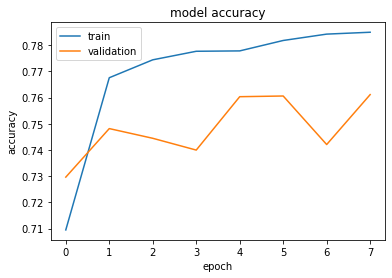

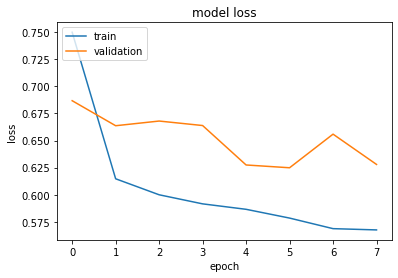

In [18]:
plot_curves(history1)

In [ ]:
save_model(myDNN, "../models/FFNN/FFNN-raw-n1.64-n2.32-kr0015-vacc7611")

In [ ]:
myDNN = model_load("../models/FFNN/FFNN-raw-n1.64-n2.32-kr0015-vacc7611.h5")

In [19]:
results1 = np.argmax(myDNN.predict(x_val_padded), axis=-1)

In [20]:
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.7611111111111111

Precision:  [0.68932039 0.83095578 0.78106509 0.68510259]
Average Precision:  0.7466109603858989

Recall:  [0.67619048 0.77408638 0.74576271 0.79175258]
Average Recall:  0.746948036028003

F1-Score:  [0.68269231 0.80151359 0.76300578 0.73457676]
Average F1-Score:  0.7454471083656766


# CNN Model

In [21]:
myCNN = create_model_CNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix, 
                         input_len, 
                         trainable=False, 
                         n1=64, k=5, 
                         d=0.25, kr=l2(0.0))
myCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          15772800  
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            96064     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 15,869,124
Trainable params: 96,324
Non-trainable params: 15,772,800
_________________________________________________________________


In [22]:
history2 = myCNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val))

Epoch 1/8
1313/1313 [==============================] - 47s 36ms/step - loss: 0.4910 - acc: 0.8225 - val_loss: 0.3911 - val_acc: 0.8537
Epoch 2/8
1313/1313 [==============================] - 52s 39ms/step - loss: 0.3312 - acc: 0.8811 - val_loss: 0.3733 - val_acc: 0.8598
Epoch 3/8
1313/1313 [==============================] - 44s 34ms/step - loss: 0.2646 - acc: 0.9050 - val_loss: 0.3738 - val_acc: 0.8661
Epoch 4/8
1313/1313 [==============================] - 44s 34ms/step - loss: 0.2174 - acc: 0.9224 - val_loss: 0.3902 - val_acc: 0.8646
Epoch 5/8
1313/1313 [==============================] - 50s 38ms/step - loss: 0.1803 - acc: 0.9361 - val_loss: 0.4004 - val_acc: 0.8653
Epoch 6/8
1313/1313 [==============================] - 53s 40ms/step - loss: 0.1528 - acc: 0.9446 - val_loss: 0.4389 - val_acc: 0.8638
Epoch 7/8
1313/1313 [==============================] - 52s 40ms/step - loss: 0.1324 - acc: 0.9524 - val_loss: 0.4443 - val_acc: 0.8614
Epoch 8/8
1313/1313 [==============================] - 

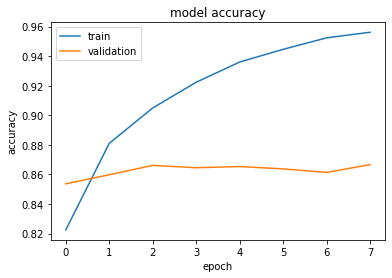

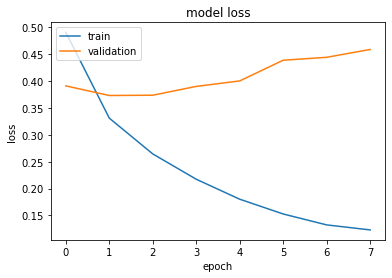

In [23]:
plot_curves(history2)

In [ ]:
save_model(myCNN, "../models/CNN/CNN-raw-n1.64n2.64-kr0015-vacc8666")

In [ ]:
myCNN = model_load("../models/CNN/CNN-raw-n1.64n2.64-kr0015-vacc8666.h5")

In [24]:
results2 = np.argmax(myCNN.predict(x_val_padded), axis=-1)

In [25]:
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8666666666666667

Precision:  [0.83819629 0.86900958 0.88329519 0.85892116]
Average Precision:  0.8623555568676051

Recall:  [0.75238095 0.90365449 0.87231638 0.85360825]
Average Recall:  0.8454900172585644

F1-Score:  [0.79297365 0.88599349 0.87777146 0.85625646]
Average F1-Score:  0.8532487652199825


# Bi-LSTM Model

In [18]:
myLSTM = create_model_LSTM(input_dim, 
                           embedding_dim, 
                           embedding_matrix, 
                           input_len, 
                           trainable=False, 
                           n1=64, n2=64, 
                           d=0.3)
myLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15772800  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          186880    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 15,968,196
Trainable params: 195,396
Non-trainable params: 15,772,800
_________________________________________________________________


In [19]:
history3 = myLSTM.fit(x_train_padded, 
                      y_train, 
                      epochs=8, 
                      batch_size=32, 
                      verbose=1, 
                      validation_data = (x_val_padded, y_val), 
                      callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 234s 179ms/step - loss: 0.4598 - acc: 0.8292 - val_loss: 0.3592 - val_acc: 0.8730
Epoch 2/8
1313/1313 [==============================] - 214s 163ms/step - loss: 0.3590 - acc: 0.8689 - val_loss: 0.3347 - val_acc: 0.8825
Epoch 3/8
1313/1313 [==============================] - 226s 172ms/step - loss: 0.3207 - acc: 0.8816 - val_loss: 0.3276 - val_acc: 0.8854
Epoch 4/8
1313/1313 [==============================] - 243s 185ms/step - loss: 0.2910 - acc: 0.8921 - val_loss: 0.3323 - val_acc: 0.8810
Epoch 5/8
1313/1313 [==============================] - 252s 192ms/step - loss: 0.2684 - acc: 0.9023 - val_loss: 0.3163 - val_acc: 0.8865
Epoch 6/8
1313/1313 [==============================] - 255s 194ms/step - loss: 0.2478 - acc: 0.9087 - val_loss: 0.3070 - val_acc: 0.8902
Epoch 7/8
1313/1313 [==============================] - 326s 248ms/step - loss: 0.2319 - acc: 0.9137 - val_loss: 0.3366 - val_acc: 0.8870
Epoch 8/8
1313/1313 [====================

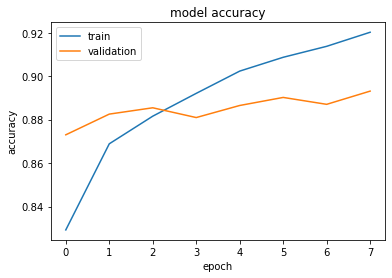

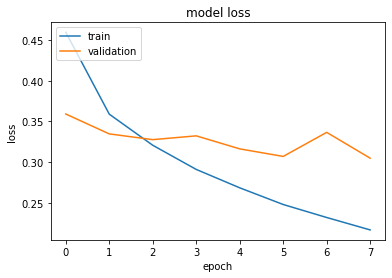

In [20]:
plot_curves(history3)

In [23]:
save_model(myLSTM, "../models/LSTM/BiLSTM-raw-n1.64-n2.64-d30-vacc-8931")

In [ ]:
myLSTM = model_load("../models/LSTM/BiLSTM-raw-n1.64-n2.64-d30-vacc-8931.h5")

In [21]:
results3 = np.argmax(myLSTM.predict(x_val_padded), axis=-1)

In [22]:
acc, precision, recall, f1 = classification_report(y_val, results3)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8931216931216931

Precision:  [0.86616162 0.90284204 0.90960452 0.87423935]
Average Precision:  0.8882118806347719

Recall:  [0.81666667 0.9076412  0.90960452 0.88865979]
Average Recall:  0.8806430440670999

F1-Score:  [0.84068627 0.90523526 0.90960452 0.88139059]
Average F1-Score:  0.8842291606166753


# BiLSTM with Attention

In [14]:
class AttentionLayer(Layer):
    
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
        
    def build(self, input_shape):
        self.W_in = self.add_weight(shape=(input_shape[-1], 1),
                                    initializer='glorot_normal',
                                    trainable=True,
                                    name='input_attention_weights')
       
        self.b = self.add_weight(shape=(input_shape[1], 1),
                                        initializer='zeros',
                                        trainable=True,
                                        name='attention_bias')
        
        super(AttentionLayer, self).build(input_shape)
        
        
    def call(self, lstm_output):
        et = K.squeeze(K.tanh(K.dot(lstm_output, self.W_in) +
                              self.b), axis=-1)
        at = K.expand_dims(K.softmax(et), axis=-1)
        attention_output = K.sum(lstm_output * at, axis=1)
        return attention_output
    
    
    def compute_output_shape(self, input_state):
        return (input_state[0], input_state[-1])
    
    
    def get_config(self):
        return super(AttentionLayer, self).get_config()

In [17]:
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim, 
                             output_dim=embedding_dim, 
                             weights=[embedding_matrix], 
                             trainable=False)(Input1)
LSTM1 = Bidirectional(LSTM(64, dropout=0.3, return_sequences=True))(Embedding_layer1)
Attention = AttentionLayer()(LSTM1)
Dense1 = Dense(64, activation='relu')(Attention)
outputs = Dense(4, activation='softmax')(Dense1)

model = Model(inputs=Input1, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          15772800  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          186880    
_________________________________________________________________
attention_layer (AttentionLa (None, 128)               228       
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 15,968,424
Trainable params: 195,624
Non-trainable params: 15,772,800
___________________________________________

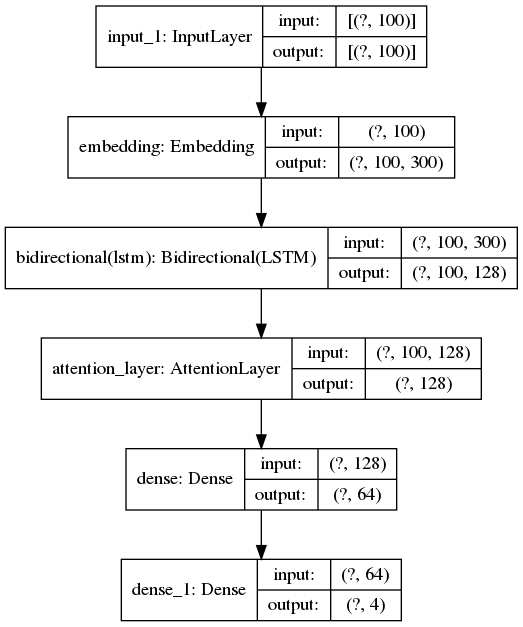

In [18]:
plot_model(model, show_shapes=True)

In [19]:
history_att = model.fit(x_train_padded,
                        y_train, 
                        epochs=8,
                        batch_size=32, 
                        verbose=1,
                        validation_data=(x_val_padded, y_val))

Epoch 1/8
1313/1313 [==============================] - 325s 247ms/step - loss: 0.4853 - acc: 0.8193 - val_loss: 0.4048 - val_acc: 0.8526
Epoch 2/8
1313/1313 [==============================] - 318s 242ms/step - loss: 0.3747 - acc: 0.8633 - val_loss: 0.3706 - val_acc: 0.8677
Epoch 3/8
1313/1313 [==============================] - 250s 190ms/step - loss: 0.3407 - acc: 0.8737 - val_loss: 0.3420 - val_acc: 0.8757
Epoch 4/8
1313/1313 [==============================] - 232s 177ms/step - loss: 0.3060 - acc: 0.8862 - val_loss: 0.3156 - val_acc: 0.8886
Epoch 5/8
1313/1313 [==============================] - 249s 190ms/step - loss: 0.2830 - acc: 0.8962 - val_loss: 0.3322 - val_acc: 0.8828
Epoch 6/8
1313/1313 [==============================] - 260s 198ms/step - loss: 0.2590 - acc: 0.9044 - val_loss: 0.3193 - val_acc: 0.8862
Epoch 7/8
1313/1313 [==============================] - 275s 210ms/step - loss: 0.2415 - acc: 0.9115 - val_loss: 0.3022 - val_acc: 0.8921
Epoch 8/8
1313/1313 [====================

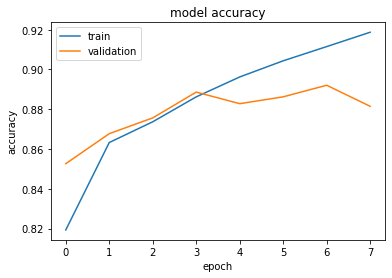

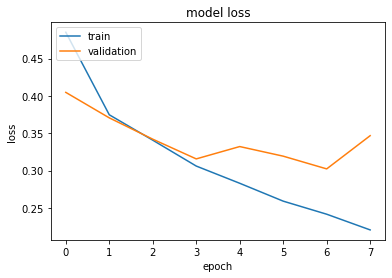

In [20]:
plot_curves(history_att)

In [21]:
results2 = np.argmax(model.predict(x_val_padded), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8814814814814815

Precision:  [0.94936709 0.83104238 0.95159236 0.89389068]
Average Precision:  0.9064731257813562

Recall:  [0.71428571 0.9641196  0.8440678  0.85979381]
Average Recall:  0.8455667316644443

F1-Score:  [0.81521739 0.89264842 0.89461078 0.87651077]
Average F1-Score:  0.8697468395210077


In [ ]:
save_model(model, "BiLSTM-Attention-f1-")

# BiLSTM-CNN Model

In [15]:
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim, 
                             output_dim=embedding_dim, 
                             weights=[embedding_matrix], 
                             trainable=False)(Input1)
LSTM1 = Bidirectional(LSTM(64, dropout=0.25, return_sequences=True))(Embedding_layer1)
Conv1 = Conv1D(64, kernel_size=5, activation='relu')(LSTM1)
max_pooling1 = MaxPooling1D(pool_size=3)(Conv1)
Dropout2 = Dropout(0.25)(max_pooling1)
Flatten1 = Flatten()(Dropout2)
Dense1 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(Flatten1)
Dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(Dense1)
output = Dense(4, activation='softmax')(Dense2)

myBiLSTM_CNN = Model(inputs=Input1, outputs=output)
myBiLSTM_CNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
myBiLSTM_CNN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          15772800  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          186880    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

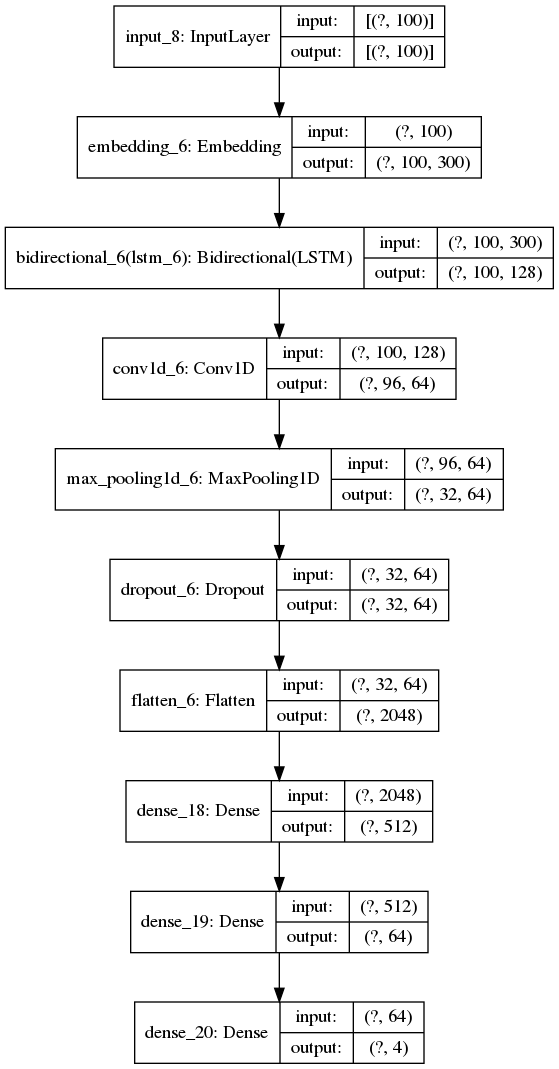

In [39]:
plot_model(myBiLSTM_CNN, show_shapes=True)

In [40]:
history = myBiLSTM_CNN.fit(x_train_padded,
                           y_train, 
                           epochs=16,
                           batch_size=128,
                           verbose=1,
                           validation_data=(x_val_padded, y_val))

Epoch 1/16
329/329 [==============================] - 169s 515ms/step - loss: 1.1156 - acc: 0.7957 - val_loss: 0.4982 - val_acc: 0.8397
Epoch 2/16
329/329 [==============================] - 185s 564ms/step - loss: 0.4463 - acc: 0.8547 - val_loss: 0.4300 - val_acc: 0.8598
Epoch 3/16
329/329 [==============================] - 345s 1s/step - loss: 0.4102 - acc: 0.8647 - val_loss: 0.4081 - val_acc: 0.8685
Epoch 4/16
329/329 [==============================] - 263s 799ms/step - loss: 0.3756 - acc: 0.8772 - val_loss: 0.3838 - val_acc: 0.8759
Epoch 5/16
329/329 [==============================] - 203s 618ms/step - loss: 0.3544 - acc: 0.8834 - val_loss: 0.3769 - val_acc: 0.8757
Epoch 6/16
329/329 [==============================] - 147s 448ms/step - loss: 0.3292 - acc: 0.8902 - val_loss: 0.3545 - val_acc: 0.8794
Epoch 7/16
329/329 [==============================] - 180s 548ms/step - loss: 0.3041 - acc: 0.8993 - val_loss: 0.3586 - val_acc: 0.8831
Epoch 8/16
329/329 [==============================]

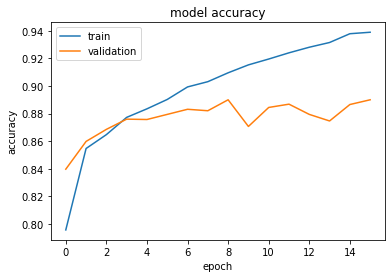

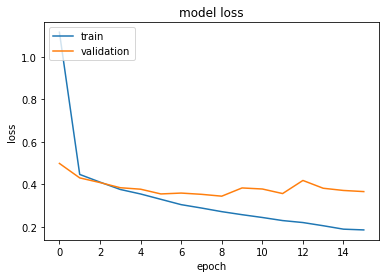

In [41]:
plot_curves(history)

In [42]:
results2 = np.argmax(myBiLSTM_CNN.predict(x_val_padded), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8899470899470899

Precision:  [0.93859649 0.88669637 0.9245509  0.85077519]
Average Precision:  0.9001547387419648

Recall:  [0.76428571 0.9255814  0.87231638 0.90515464]
Average Recall:  0.86683453324765

F1-Score:  [0.84251969 0.90572172 0.89767442 0.87712288]
Average F1-Score:  0.8807596743204631


In [43]:
save_model(myBiLSTM_CNN, "BiLSTM-CNN-f1-8807")

# BiLSTM-CNN Model with Attention

In [22]:
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim, 
                             output_dim=embedding_dim, 
                             weights=[embedding_matrix], 
                             trainable=False)(Input1)

LSTM1 = Bidirectional(LSTM(128, dropout=0.25, return_sequences=True))(Embedding_layer1)
Conv1 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(LSTM1)
Dropout2 = Dropout(0.25)(Conv1)

Attention = AttentionLayer()(Dropout2)
Dense2 = Dense(64, activation='relu')(Attention)
Dropout3 = Dropout(0.3)(Dense2)
output = Dense(4, activation='softmax')(Dropout3)

myBiLSTM_CNN_Att = Model(inputs=Input1, outputs=output)
myBiLSTM_CNN_Att.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
myBiLSTM_CNN_Att.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15772800  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          439296    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 128)          163968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
attention_layer_1 (Attention (None, 128)               228       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256

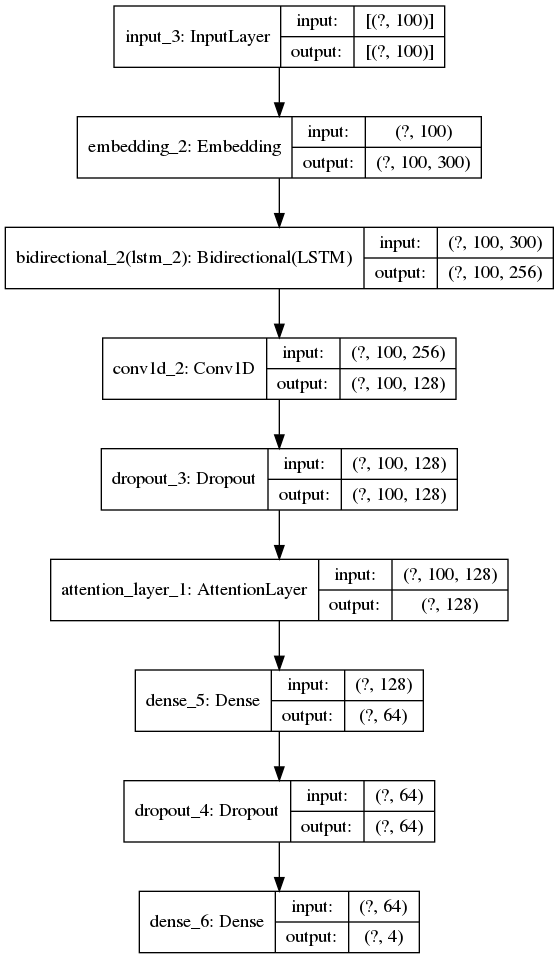

In [23]:
plot_model(myBiLSTM_CNN_Att, show_shapes=True)

In [18]:
model_checkpoint_callback = ModelCheckpoint(filepath="../models/BiLSTM-CNN-Attention/BiLSTM-CNN-Attention.{epoch:02d}-{val_loss:.2f}.h5",
                                            save_weights_only=True,
                                            monitor='val_accuracy', 
                                            mode='max',
                                            save_best_only=True)

In [24]:
history = myBiLSTM_CNN_Att.fit(x_train_padded,
                               y_train, 
                               epochs=30,
                               batch_size=128,
                               verbose=1,
                               validation_data=(x_val_padded, y_val),
                               callbacks=[myCB])

Epoch 1/30
329/329 [==============================] - 313s 950ms/step - loss: 0.5198 - acc: 0.8092 - val_loss: 0.3945 - val_acc: 0.8593
Epoch 2/30
329/329 [==============================] - 294s 894ms/step - loss: 0.3953 - acc: 0.8588 - val_loss: 0.3711 - val_acc: 0.8630
Epoch 3/30
329/329 [==============================] - 225s 683ms/step - loss: 0.3657 - acc: 0.8683 - val_loss: 0.3483 - val_acc: 0.8712
Epoch 4/30
329/329 [==============================] - 239s 727ms/step - loss: 0.3329 - acc: 0.8773 - val_loss: 0.3295 - val_acc: 0.8820
Epoch 5/30
329/329 [==============================] - 254s 772ms/step - loss: 0.3034 - acc: 0.8895 - val_loss: 0.3269 - val_acc: 0.8833
Epoch 6/30
329/329 [==============================] - 258s 784ms/step - loss: 0.2821 - acc: 0.8985 - val_loss: 0.3368 - val_acc: 0.8778
Epoch 7/30
329/329 [==============================] - 263s 798ms/step - loss: 0.2627 - acc: 0.9054 - val_loss: 0.3137 - val_acc: 0.8873
Epoch 8/30
329/329 [============================

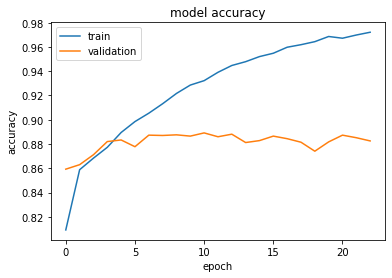

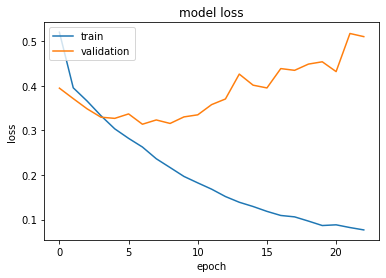

In [25]:
plot_curves(history)

In [26]:
results = np.argmax(myBiLSTM_CNN_Att.predict(x_val_padded), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8825396825396825

Precision:  [0.89041096 0.85722965 0.94022416 0.8747412 ]
Average Precision:  0.8906514916912821

Recall:  [0.77380952 0.93754153 0.85310734 0.87113402]
Average Recall:  0.8588981043250129

F1-Score:  [0.82802548 0.8955887  0.89454976 0.87293388]
Average F1-Score:  0.8727744567592669


In [28]:
save_model(myBiLSTM_CNN_Att, "LSTM+CNN/BiLSTM-CNN-Attention-f1-8727")